<type 'numpy.ndarray'>
5636 5636
5636
[ 0.04        0.03566667  0.02833333  0.02766667  0.03533333  0.03266667
  0.02366667  0.02733333  0.02366667  0.01533333  0.01633333  0.01433333
  0.013       0.00833333]
<type 'numpy.ndarray'>
5608 5608
5608
[ 0.039       0.03733333  0.03466667  0.03133333  0.03066667  0.02933333
  0.02333333  0.027       0.025       0.01766667  0.021       0.01733333
  0.01133333  0.008     ]
<type 'numpy.ndarray'>
5665 5665
5665
[ 0.047       0.037       0.035       0.02833333  0.026       0.028
  0.02466667  0.02433333  0.01566667  0.02233333  0.01866667  0.018
  0.01233333  0.008     ]
<type 'numpy.ndarray'>
11423 11423
11423
[ 0.115       0.12466667  0.115       0.11866667  0.11166667  0.10733333
  0.12166667  0.116       0.12033333  0.118       0.10266667  0.11233333
  0.10566667  0.11666667]
Converged with chi squared  0.00464160850876
degrees of freedom, dof  12
RMS of residuals (i.e. sqrt(chisq/dof))  0.0196672496568
Reduced chisq (i.e. variance of resid

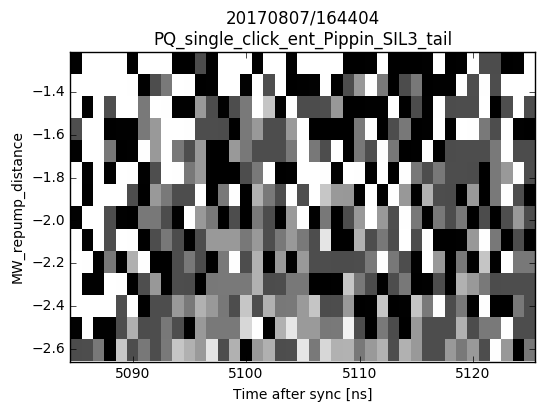

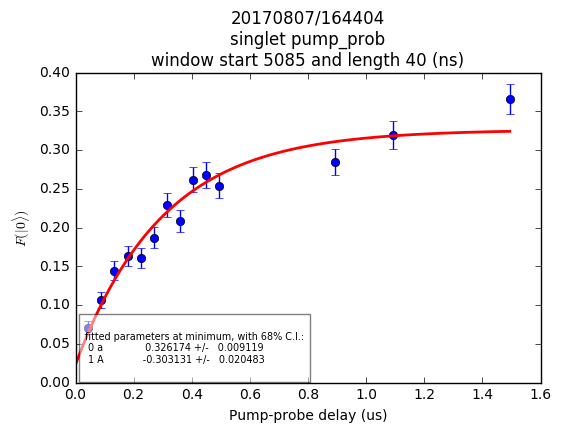

In [79]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
%matplotlib inline

cum_reps = 0
syncs_per_sweep = 1
sweep_length = 0
folder_normalization = tb.latest_data('164001')
window_start = 5085
window_length = 40

t_list = ['164057','164311','164404']

for t in t_list:

    name = 'adwindata'
    folder_msmt=tb.latest_data(t)
    a = pqsequence.TailAnalysis(folder_msmt, hdf5_mode='r', pq_device = '')
    a.get_sweep_pts()
    a.get_sweep_idxs(noof_syncs_per_sweep_pt=1)
    a.get_readout_results(name)
    a.get_tail_vs_sweep(0,window_start,window_length, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=False)
    cum_reps += a.reps
    if t == t_list[0]:
        cum_tail_cts_per_sweep_idx = a.tail_cts_per_sweep_idx/len(t_list)
    else:
        cum_tail_cts_per_sweep_idx += a.tail_cts_per_sweep_idx/len(t_list)

x = a.sweep_pts ### correction factor for distance
y = cum_tail_cts_per_sweep_idx
y_err = np.sqrt(cum_tail_cts_per_sweep_idx)/np.sqrt((cum_reps*syncs_per_sweep/a.sweep_length))
sweep_length = a.sweep_length

save = True
a.plot_tail_hists_vs_sweep(save=False,log_plot = True)



### rescale the x-axis:
# min distance between pump and probe is 44 ns for a window start of 5080 ns.
x = x*(-1)
x = x-np.amin(x)+0.044 + (window_start-5085)*1e-3

### normalize to the reference msmt (we only detect counts from ms=0)
b = pqsequence.TailAnalysis(folder_normalization, hdf5_mode='r', pq_device = '')
b.get_sweep_pts()
b.get_sweep_idxs(noof_syncs_per_sweep_pt=1)
b.get_readout_results(name)
b.get_tail_vs_sweep(0,window_start,window_length, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=False)
norm_y_err = np.sqrt(b.tail_cts_per_sweep_idx)/np.sqrt((b.reps*syncs_per_sweep/b.sweep_length))
y_norm = np.average(b.tail_cts_per_sweep_idx)
norm_y_err = np.sqrt(np.sum(norm_y_err**2))/len(norm_y_err)

y_err = np.sqrt((y_norm*y_err)**2+(y*norm_y_err)**2)/y_norm**2
y = y/y_norm

fig = plt.figure()
ax = plt.subplot(111)
ax.errorbar(x,y,y_err,fmt='bo')
p0,fitfunc,fitfunc_str = common.fit_exp_decay_shifted_with_offset(np.amax(y),-np.amax(y)/3.,0.3,0)
fit_result = fit.fit1d(x,y,None,p0=p0,fitfunc=fitfunc,do_print=True,fixed=[2,3],ret=True)
plot.plot_fit1d(fit_result,np.linspace(0.,np.amax(x),100),ax=ax,plot_data=False)#,info_xy = [0.69,0.07])
ax.set_xlabel('Pump-probe delay (us)')
ax.set_ylabel(r'$F(|0\rangle)$')
# ax.set_ylabel(r'p(photon)')
ax.set_title(a.timestamp+'\n'+'singlet pump_prob'+'\n'+'window start %i and length %i (ns)' %(window_start,window_length))
a.save_fig_incremental_filename(fig,'singlet_pump_prob')
plt.show()


In [42]:
np.array([0,1,2])**2

array([0, 1, 4])

<type 'numpy.ndarray'>
52741 52741
52741
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Converged with chi squared  28907.4517138
degrees of freedom, dof  47
RMS of residuals (i.e. sqrt(chisq/dof))  24.8002452432
Reduced chisq (i.e. variance of residuals)  615.052164124

fitted parameters at minimum, with 68% C.I.:
 0 a             13.216589 +/-   8.093683
 1 A           2691.612359 +/-  13.680726
 2 tau           11.657821 +/-   0.146666

correlation matrix:
               a         A         tau       
         a  1.000000
         A -0.201919  1.000000
       tau -0.810000 -0.225910  1.000000



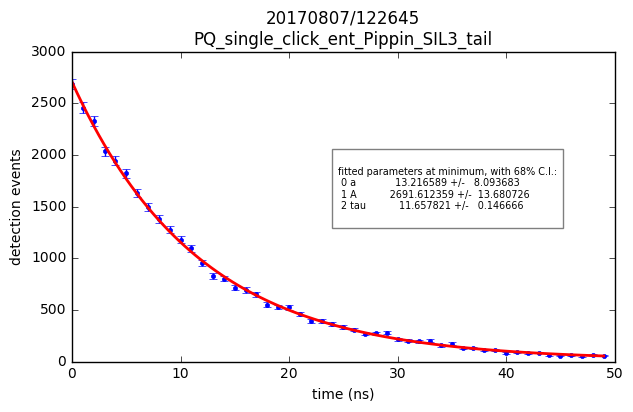

In [76]:
## fit an exponential decay to our beloved histogram.
#151757
folder_msmt = tb.latest_data('122645')
a = pqsequence.TailAnalysis(folder_msmt, hdf5_mode='r', pq_device = '')
a.get_sweep_pts()
a.get_sweep_idxs(noof_syncs_per_sweep_pt=1)
a.get_readout_results('adwindata')
a.get_tail_vs_sweep(0,window_start,window_length, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=False)
hist_start = 2775
hist_length = 50

is_ph = pq_tools.get_photons(a.pqf)[0]
bins = np.arange(hist_start-.5,hist_start+hist_length,1)
y,x=np.histogram(a.pqf['/PQ_sync_time-1'].value[np.where(is_ph)], bins=bins)
# ax = plt.subplot(111)
x=x[:-1]
x = x-np.amin(x)
fig = a.default_fig(figsize = (7,4))
ax = a.default_ax(fig=fig)
ax.set_xlabel('time (ns)')
ax.set_ylabel('detection events')
ax.errorbar(x,y,np.sqrt(y),fmt='.')
p0,fitfunc,fitfunc_str = common.fit_exp_decay_with_offset(np.amax(y),np.amax(y)/3.,8)
fit_result = fit.fit1d(x,y,None,p0=p0,fitfunc=fitfunc,do_print=True,fixed=[],ret=True)
plot.plot_fit1d(fit_result,np.linspace(0.,np.amax(x),100),ax=ax,plot_data=False,info_xy = [np.amax(x)/2.,np.amax(y)/2.])
a.save_fig_incremental_filename(fig,'exponential_decay')

In [ ]:
fig = a.default_fig